Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Training an Object Detection model using AutoML
In this notebook, we go over how you can use AutoML for training an Object Detection model. We will use a small dataset to train the model, demonstrate how you can tune hyperparameters of the model to optimize model performance and deploy the model to use in inference scenarios. For detailed information please refer to the [documentation of AutoML for Images](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models).

![img](example_object_detection_predictions.jpg)

**Important:** This feature is currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see [Supplemental Terms of Use for Microsoft Azure Previews](https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/).

## Environment Setup
Please follow the ["Setup a new conda environment"](https://github.com/Azure/azureml-examples/tree/main/python-sdk/tutorials/automl-with-azureml#3-setup-a-new-conda-environment) instructions to get started.

In [1]:
import azureml.core

print("This notebook was created using version 1.35.0 of the Azure ML SDK.")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK.")
assert (
    azureml.core.VERSION >= "1.35"
), "Please upgrade the Azure ML SDK by running '!pip install --upgrade azureml-sdk' then restart the kernel."

Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (azureml-train-core 1.40.0 (c:\users\rvadthyavath\anaconda3\envs\xaibenchmarks\lib\site-packages), Requirement.parse('azureml-train-core~=0.1.0.69255225')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (azure-core 1.24.1 (c:\users\rvadthyavath\anaconda3\envs\xaibenchmarks\lib\site-packages), Requirement.parse('azure-core<1.22'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (azure-core 1.24.1 (c:\users\rvadthyavath\anaconda3\envs\xaibenchmarks\lib\site-packages), Requirement.parse('azure-core<1.22')).


This notebook was created using version 1.35.0 of the Azure ML SDK.
You are currently using version 1.40.0 of the Azure ML SDK.


## Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription or load an existing workspace.

In [2]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()

## Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [3]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpu-cluster-nc6"

try:
    compute_target = ws.compute_targets[cluster_name]
    print("Found existing compute target.")
except KeyError:
    print("Creating a new compute target...")
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_NC6",
        idle_seconds_before_scaledown=600,
        min_nodes=0,
        max_nodes=4,
    )
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(
    show_output=True, min_node_count=None, timeout_in_minutes=20
)

Creating a new compute target...
InProgress....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Experiment Setup
Create an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#experiments) in your workspace to track your model training runs

In [4]:
from azureml.core import Experiment

experiment_name = "automl-image-object-detection"
experiment = Experiment(ws, name=experiment_name)

## Dataset with input Training Data

In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset). You can either use a dataset that you have exported from a [Data Labeling](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-label-data) project, or create a new Tabular Dataset with your labeled training data.

In this notebook, we use a toy dataset called Fridge Objects, which consists of 128 images of 4 classes of beverage container {can, carton, milk bottle, water bottle} photos taken on different backgrounds.

All images in this notebook are hosted in [this repository](https://github.com/microsoft/computervision-recipes) and are made available under the [MIT license](https://github.com/microsoft/computervision-recipes/blob/master/LICENSE).

We first download and unzip the data locally.

In [5]:
import os
import urllib
from zipfile import ZipFile

# download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
data_file = "./odFridgeObjects.zip"
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall()
    print("done")
# delete zip file
os.remove(data_file)

extracting files...
done


This is a sample image from this dataset:

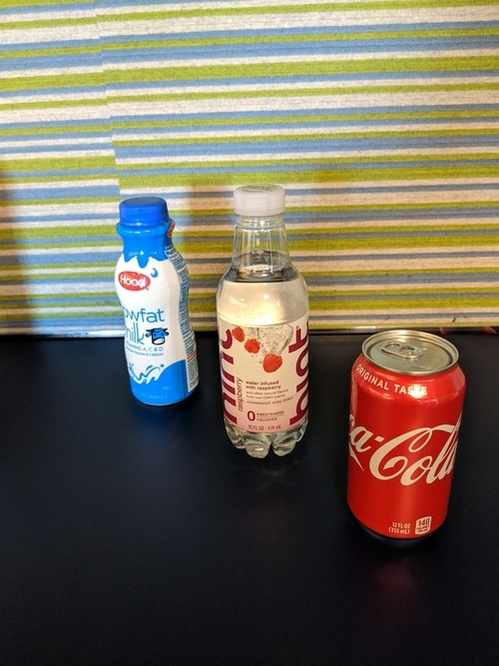

In [6]:
from IPython.display import Image

Image(filename="./odFridgeObjects/images/31.jpg")

### Convert the downloaded data to JSONL
In this example, the fridge object dataset is annotated in Pascal VOC format, where each image corresponds to an xml file. Each xml file contains information on where its corresponding image file is located and also contains information about the bounding boxes and the object labels. In order to use this data to create an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset), we first need to convert it to the required JSONL format. Please refer to the [documentation on how to prepare datasets](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-prepare-datasets-for-automl-images).

The following script is creating two .jsonl files (one for training and one for validation) in the parent folder of the dataset. The train / validation ratio corresponds to 20% of the data going into the validation file.

In [7]:
import json
import os
import xml.etree.ElementTree as ET

src = "./odFridgeObjects/"
train_validation_ratio = 5

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the annotations
annotations_folder = os.path.join(src, "annotations")

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = {
    "image_url": "AmlDatastore://"
    + workspaceblobstore
    + "/"
    + os.path.basename(os.path.dirname(src))
    + "/"
    + "images",
    "image_details": {"format": None, "width": None, "height": None},
    "label": [],
}

# Read each annotation and convert it to jsonl line
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for i, filename in enumerate(os.listdir(annotations_folder)):
            if filename.endswith(".xml"):
                print("Parsing " + os.path.join(src, filename))

                root = ET.parse(os.path.join(annotations_folder, filename)).getroot()

                width = int(root.find("size/width").text)
                height = int(root.find("size/height").text)

                labels = []
                for object in root.findall("object"):
                    name = object.find("name").text
                    xmin = object.find("bndbox/xmin").text
                    ymin = object.find("bndbox/ymin").text
                    xmax = object.find("bndbox/xmax").text
                    ymax = object.find("bndbox/ymax").text
                    isCrowd = int(object.find("difficult").text)
                    labels.append(
                        {
                            "label": name,
                            "topX": float(xmin) / width,
                            "topY": float(ymin) / height,
                            "bottomX": float(xmax) / width,
                            "bottomY": float(ymax) / height,
                            "isCrowd": isCrowd,
                        }
                    )
                # build the jsonl file
                image_filename = root.find("filename").text
                _, file_extension = os.path.splitext(image_filename)
                json_line = dict(json_line_sample)
                json_line["image_url"] = json_line["image_url"] + "/" + image_filename
                json_line["image_details"]["format"] = file_extension[1:]
                json_line["image_details"]["width"] = width
                json_line["image_details"]["height"] = height
                json_line["label"] = labels

                if i % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
            else:
                print("Skipping unknown file: {}".format(filename))

Parsing ./odFridgeObjects/1.xml
Parsing ./odFridgeObjects/10.xml
Parsing ./odFridgeObjects/100.xml
Parsing ./odFridgeObjects/101.xml
Parsing ./odFridgeObjects/102.xml
Parsing ./odFridgeObjects/103.xml
Parsing ./odFridgeObjects/104.xml
Parsing ./odFridgeObjects/105.xml
Parsing ./odFridgeObjects/106.xml
Parsing ./odFridgeObjects/107.xml
Parsing ./odFridgeObjects/108.xml
Parsing ./odFridgeObjects/109.xml
Parsing ./odFridgeObjects/11.xml
Parsing ./odFridgeObjects/110.xml
Parsing ./odFridgeObjects/111.xml
Parsing ./odFridgeObjects/112.xml
Parsing ./odFridgeObjects/113.xml
Parsing ./odFridgeObjects/114.xml
Parsing ./odFridgeObjects/115.xml
Parsing ./odFridgeObjects/116.xml
Parsing ./odFridgeObjects/117.xml
Parsing ./odFridgeObjects/118.xml
Parsing ./odFridgeObjects/119.xml
Parsing ./odFridgeObjects/12.xml
Parsing ./odFridgeObjects/120.xml
Parsing ./odFridgeObjects/121.xml
Parsing ./odFridgeObjects/122.xml
Parsing ./odFridgeObjects/123.xml
Parsing ./odFridgeObjects/124.xml
Parsing ./odFridgeO

### Convert annotation file from COCO to JSONL
If you want to try with a dataset in COCO format, the scripts below shows how to convert it to `jsonl` format. The file "odFridgeObjects_coco.json" consists of annotation information for the `odFridgeObjects` dataset.

In [8]:
# Generate jsonl file from coco file
!python coco2jsonl.py \
--input_coco_file_path "./odFridgeObjects_coco.json" \
--output_dir "./odFridgeObjects" --output_file_name "odFridgeObjects_from_coco.jsonl" \
--task_type "ObjectDetection" \
--base_url "AmlDatastore://workspaceblobstore/odFridgeObjects/images/"

Converting for ObjectDetection
Conversion completed. Converted 128 lines.


### Visualize bounding boxes
Please refer to the "Visualize data" section in the following [tutorial](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-auto-train-image-models#visualize-data) to see how to easily visualize your ground truth bounding boxes before starting to train.

### Upload the JSONL file and images to Datastore
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data and interact with it from your remote compute targets. It is an abstraction over Azure Storage.

In [9]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir="./odFridgeObjects", target_path="odFridgeObjects")

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 260 files
Target already exists. Skipping upload for odFridgeObjects\.DS_Store
Target already exists. Skipping upload for odFridgeObjects\train_annotations.jsonl
Target already exists. Skipping upload for odFridgeObjects\validation_annotations.jsonl
Target already exists. Skipping upload for odFridgeObjects\annotations\1.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\10.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\100.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\101.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\102.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\103.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\104.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\105.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\106.xml
Target already e

Target already exists. Skipping upload for odFridgeObjects\annotations\76.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\77.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\78.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\79.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\8.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\80.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\81.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\82.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\83.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\84.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\85.xml
Target already exists. Skipping upload for odFridgeObjects\annotations\86.xml
Target already exists. Skipping upload for odFridgeObjects\annota

Target already exists. Skipping upload for odFridgeObjects\images\60.jpg
Target already exists. Skipping upload for odFridgeObjects\images\61.jpg
Target already exists. Skipping upload for odFridgeObjects\images\62.jpg
Target already exists. Skipping upload for odFridgeObjects\images\63.jpg
Target already exists. Skipping upload for odFridgeObjects\images\64.jpg
Target already exists. Skipping upload for odFridgeObjects\images\65.jpg
Target already exists. Skipping upload for odFridgeObjects\images\66.jpg
Target already exists. Skipping upload for odFridgeObjects\images\67.jpg
Target already exists. Skipping upload for odFridgeObjects\images\68.jpg
Target already exists. Skipping upload for odFridgeObjects\images\69.jpg
Target already exists. Skipping upload for odFridgeObjects\images\7.jpg
Target already exists. Skipping upload for odFridgeObjects\images\70.jpg
Target already exists. Skipping upload for odFridgeObjects\images\71.jpg
Target already exists. Skipping upload for odFridgeO

$AZUREML_DATAREFERENCE_516f31d4a621483494e42f589949154c

Finally, we need to create an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [10]:
from azureml.core import Dataset
from azureml.data import DataType

# get existing training dataset
training_dataset_name = "odFridgeObjectsTrainingDataset"
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print("Found the training dataset", training_dataset_name)
else:
    # create training dataset
    training_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path("odFridgeObjects/train_annotations.jsonl"),
        set_column_types={"image_url": DataType.to_stream(ds.workspace)},
    )
    training_dataset = training_dataset.register(
        workspace=ws, name=training_dataset_name
    )
# get existing validation dataset
validation_dataset_name = "odFridgeObjectsValidationDataset"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print("Found the validation dataset", validation_dataset_name)
else:
    # create validation dataset
    validation_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path("odFridgeObjects/validation_annotations.jsonl"),
        set_column_types={"image_url": DataType.to_stream(ds.workspace)},
    )
    validation_dataset = validation_dataset.register(
        workspace=ws, name=validation_dataset_name
    )
print("Training dataset name: " + training_dataset.name)
print("Validation dataset name: " + validation_dataset.name)

Found the training dataset odFridgeObjectsTrainingDataset
Found the validation dataset odFridgeObjectsValidationDataset
Training dataset name: odFridgeObjectsTrainingDataset
Validation dataset name: odFridgeObjectsValidationDataset


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#model-agnostic-hyperparameters) for more details.

This is what the training dataset looks like:

In [11]:
training_dataset.to_pandas_dataframe()

,image_url,image_details,label
0,workspaceblobstore/odFridgeObjects/images/10.jpg,"{'format': 'jpg', 'width': 499, 'height': 666}","[{'label': 'carton', 'topX': 0.172344689378757..."
1,workspaceblobstore/odFridgeObjects/images/100.jpg,"{'format': 'jpg', 'width': 499, 'height': 666}","[{'label': 'can', 'topX': 0.2605210420841683, ..."
2,workspaceblobstore/odFridgeObjects/images/101.jpg,"{'format': 'jpg', 'width': 499, 'height': 666}","[{'label': 'water_bottle', 'topX': 0.130260521..."
3,workspaceblobstore/odFridgeObjects/images/102.jpg,"{'format': 'jpg', 'width': 499, 'height': 666}","[{'label': 'water_bottle', 'topX': 0.278557114..."
4,workspaceblobstore/odFridgeObjects/images/104.jpg,"{'format': 'jpg', 'width': 499, 'height': 666}","[{'label': 'can', 'topX': 0.35070140280561124,..."
...,...,...,...
97,workspaceblobstore/odFridgeObjects/images/94.jpg,"{'format': 'jpg', 'width': 499, 'height': 666}","[{'label': 'carton', 'topX': 0.036072144288577..."
98,workspaceblobstore/odFridgeObjects/images/95.jpg,"{'format': 'jpg', 'width': 499, 'height': 666}","[{'label': 'carton', 'topX': 0.208416833667334..."
99,workspaceblobstore/odFridgeObjects/images/96.jpg,"{'format': 'jpg', 'width': 499, 'height': 666}","[{'label': 'carton', 'topX': 0.172344689378757..."
100,workspaceblobstore/odFridgeObjects/images/98.jpg,"{'format': 'jpg', 'width': 499, 'height': 666}","[{'label': 'carton', 'topX': 0.090180360721442..."


## Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML Image run are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-your-experiment-settings) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple models. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values for a given model to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This allows an iterative approach, as with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially, and  you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say `yolov5`), you can specify the config for your AutoML Image runs as follows:

In [ ]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

image_config_yolov5 = AutoMLImageConfig(
    task=ImageTask.IMAGE_OBJECT_DETECTION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    hyperparameter_sampling=GridParameterSampling({"model_name": choice("yolov5")}),
    iterations=1,
)

## Submitting an AutoML run for Computer Vision tasks
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train a vision model using your training dataset.

In [ ]:
automl_image_run = experiment.submit(image_config_yolov5)

In [ ]:
automl_image_run.wait_for_completion(wait_post_processing=True)

### Hyperparameter sweeping for your AutoML models for computer vision tasks

In this example, we use the AutoMLImageConfig to train an Object Detection model using `yolov5` and `fasterrcnn_resnet50_fpn`, both of which are pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label categories.

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, choosing from a range of values for `learning_rate`, `optimizer`, `lr_scheduler`, etc., to generate a model with the optimal primary metric. If hyperparameter values are not specified, then default values are used for the specified algorithm.

We use Random Sampling to pick samples from this parameter space and try a total of 10 iterations with these different samples, running 2 iterations at a time on our compute target, which has been previously set up using 4 nodes. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

In [12]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import BanditPolicy, RandomParameterSampling
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    "model": choice(
        {
            "model_name": choice("yolov5"),
            "learning_rate": uniform(0.0001, 0.01),
            "model_size": choice("small", "medium"),  # model-specific
            #'img_size': choice(640, 704, 768), # model-specific; might need GPU with large memory
        },
        {
            "model_name": choice("fasterrcnn_resnet50_fpn"),
            "learning_rate": uniform(0.0001, 0.001),
            "optimizer": choice("sgd", "adam", "adamw"),
            "min_size": choice(600, 800),  # model-specific
            #'warmup_cosine_lr_warmup_epochs': choice(0, 3),
        },
    ),
}

tuning_settings = {
    "iterations": 1,
    "max_concurrent_iterations": 2,
    "hyperparameter_sampling": RandomParameterSampling(parameter_space),
    "early_termination_policy": BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
}

automl_image_config = AutoMLImageConfig(
    task=ImageTask.IMAGE_OBJECT_DETECTION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    **tuning_settings,
)

In [13]:
automl_image_run = experiment.submit(automl_image_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-image-object-detection,AutoML_ea34cda3-9f80-4fae-bed2-83284fdba4b4,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [14]:
automl_image_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_ea34cda3-9f80-4fae-bed2-83284fdba4b4',
 'target': 'gpu-cluster-nc6',
 'status': 'Completed',
 'startTimeUtc': '2022-08-16T21:29:12.025051Z',
 'endTimeUtc': '2022-08-16T21:48:22.264359Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'mean_average_precision',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-cluster-nc6',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-image-object-detection","subscription_id":"381b38e9-9840-4719-a5a0-61d9585e1e91","resource_group":"automlimage_eastus2_rg","workspace_name":"nilesh-deployment-test","region":"eastus","compute_target":"gpu-cluster-nc6","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":true,"

When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child runs' tab in the UI of the main `automl_image_run` from above, which is the HyperDrive parent run. Then you can go into the 'Child runs' tab of this HyperDrive parent run. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Child runs' tab:

In [ ]:
from azureml.core import Run

hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + "_HD")
hyperdrive_run

## Register the optimal vision model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [30]:
# Register the model from the best run

best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties["model_name"]
model = best_child_run.register_model(
    model_name=model_name, model_path="outputs/model.pt"
)

## Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). Please note that ACI only supports small models under 1 GB in size. For testing larger models or for the high-scale production stage, we recommend using AKS.
In this tutorial, we will deploy the model as a web service in AKS.

You will need to first create an AKS compute cluster or use an existing AKS cluster. You can use either GPU or CPU VM SKUs for your deployment cluster

In [31]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "aks-cpu-od"
# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing compute target")
except ComputeTargetException:
    print("Creating a new compute target...")
    # Provision AKS cluster with a CPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_D3_V2")
    # Create the cluster
    aks_target = ComputeTarget.create(
        workspace=ws, name=aks_name, provisioning_configuration=prov_config
    )
    aks_target.wait_for_completion(show_output=True)

Creating a new compute target...
InProgress..................................................................................................................................
SucceededProvisioning operation finished, operation "Succeeded"


Next, you will need to define the [inference configuration](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#update-inference-configuration), that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.

<b>Note:</b> To change the model's settings, open the downloaded scoring script and modify the model_settings variable <i>before</i> deploying the model.

In [32]:
from azureml.core.model import InferenceConfig

best_child_run.download_file(
    "outputs/scoring_file_v_1_0_0.py", output_file_path="score.py"
)
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script="score.py", environment=environment)

You can then deploy the model as an AKS web service.

In [33]:
# Deploy the model from the best run as an AKS web service
from azureml.core.webservice import AksWebservice
from azureml.core.model import Model

aks_config = AksWebservice.deploy_configuration(
    autoscale_enabled=True, cpu_cores=1, memory_gb=5, enable_app_insights=True
)

aks_service = Model.deploy(
    ws,
    models=[model],
    inference_config=inference_config,
    deployment_config=aks_config,
    deployment_target=aks_target,
    name="automl-image-test-cpu-od",
    overwrite=True,
)
aks_service.wait_for_deployment(show_output=True)
print(aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-08-17 21:14:29+05:30 Creating Container Registry if not exists.
2022-08-17 21:14:29+05:30 Registering the environment.
2022-08-17 21:14:30+05:30 Use the existing image.
2022-08-17 21:14:33+05:30 Creating resources in AKS.
2022-08-17 21:14:34+05:30 Submitting deployment to compute.
2022-08-17 21:14:34+05:30 Checking the status of deployment automl-image-test-cpu-od..
2022-08-17 21:22:08+05:30 Checking the status of deployment automl-image-test-cpu-od..
2022-08-17 21:33:50+05:30 Checking the status of inference endpoint automl-image-test-cpu-od.
Succeeded
AKS service creation operation finished, operation "Succeeded"
Healthy


## Test the web service
Finally, let's test our deployed web service to predict new images. You can pass in any image. In this case, we'll use a random image from the dataset and pass it to the scoring URI.

In [34]:
import base64
from io import BytesIO
from PIL import Image


def img_to_base64(img_path):
    """Load and convert pillow image to base64-encoded image"""

    img = Image.open(img_path)
    imgio = BytesIO()
    img.save(imgio, img.format)
    img_str = base64.b64encode(imgio.getvalue())
    return img_str.decode('utf-8')

In [35]:
import requests
import json

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

# Set the content type
headers = {"Content-Type": "application/octet-stream"}

# If authentication is enabled, set the authorization header
headers["Authorization"] = f"Bearer {key}"

### Inference on single image in bytes format

In [36]:
sample_image = "./test_image_1.jpg"

# Load image data
data = open(sample_image, "rb").read()

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print(resp.text)

{"filename": "/tmp/tmpd3xbc1ng/tmpqs7enggk", "boxes": [{"box": {"topX": 0.22644396464029948, "topY": 0.29390899658203123, "bottomX": 0.4006332651774089, "bottomY": 0.6142437744140625}, "label": "milk_bottle", "score": 0.997672975063324}, {"box": {"topX": 0.6929021708170573, "topY": 0.4939656066894531, "bottomX": 0.9368324788411458, "bottomY": 0.8199351501464843}, "label": "can", "score": 0.9962755441665649}, {"box": {"topX": 0.43182942708333333, "topY": 0.27843589782714845, "bottomX": 0.6258265177408854, "bottomY": 0.7010505676269532}, "label": "water_bottle", "score": 0.987611711025238}]}



### Inference on single image in base64 format

In [37]:
sample_image = "./test_image_1.jpg"
json_data = json.dumps({'image': img_to_base64(sample_image)})
resp = requests.post(scoring_uri, json_data, headers=headers)
predictions = json.loads(resp.text)
predictions

{'filename': '/tmp/tmp70s0a91r/tmp08nz3n4u',
 'boxes': [{'box': {'topX': 0.2264373270670573,
    'topY': 0.2951706504821777,
    'bottomX': 0.4009474690755208,
    'bottomY': 0.6154443359375},
   'label': 'milk_bottle',
   'score': 0.9973238706588745},
  {'box': {'topX': 0.6922730509440104,
    'topY': 0.4933078384399414,
    'bottomX': 0.937359619140625,
    'bottomY': 0.8195333862304688},
   'label': 'can',
   'score': 0.9963297247886658},
  {'box': {'topX': 0.4329845174153646,
    'topY': 0.2791157341003418,
    'bottomX': 0.627056884765625,
    'bottomY': 0.7002839660644531},
   'label': 'water_bottle',
   'score': 0.98759925365448}]}

### Inference on multiple images in base64 format

In [38]:
sample_images = ["./test_image_1.jpg", "./test_image_2.jpg"]
json_data = json.dumps({'image': [img_to_base64(img_path) for img_path in sample_images]})
resp = requests.post(scoring_uri, json_data, headers=headers)
predictions = json.loads("[{}]".format(resp.text.replace('}{', '},{')))
predictions

[{'filename': '/tmp/tmpbcom3abu/tmpwwh3mu8c',
  'boxes': [{'box': {'topX': 0.2264373270670573,
     'topY': 0.2951706504821777,
     'bottomX': 0.4009474690755208,
     'bottomY': 0.6154443359375},
    'label': 'milk_bottle',
    'score': 0.9973238706588745},
   {'box': {'topX': 0.6922730509440104,
     'topY': 0.4933078384399414,
     'bottomX': 0.937359619140625,
     'bottomY': 0.8195333862304688},
    'label': 'can',
    'score': 0.9963297247886658},
   {'box': {'topX': 0.4329845174153646,
     'topY': 0.2791157341003418,
     'bottomX': 0.627056884765625,
     'bottomY': 0.7002839660644531},
    'label': 'water_bottle',
    'score': 0.98759925365448}]},
 {'filename': '/tmp/tmpbcom3abu/tmpgsn0xd5a',
  'boxes': [{'box': {'topX': 0.32021987915039063,
     'topY': 0.2176786994934082,
     'bottomX': 0.6652069600423177,
     'bottomY': 0.8238315582275391},
    'label': 'carton',
    'score': 0.997890055179596},
   {'box': {'topX': 0.6229299926757812,
     'topY': 0.4742970275878906,
  

## Visualize detections
Now that we have scored a test image, we can visualize the bounding boxes for this image

milk_bottle: [112.992, 196.584, 87.081, 213.302], 0.997
can: [345.444, 328.543, 122.298, 217.266], 0.996
water_bottle: [216.059, 185.891, 96.842, 280.498], 0.988


<Figure size 1296x864 with 0 Axes>

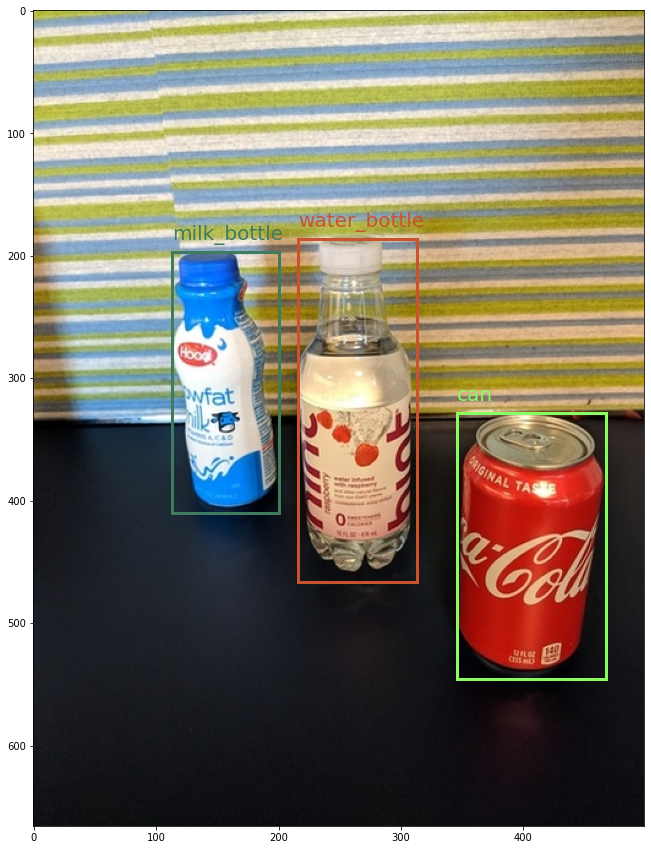

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_images[0])
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

# draw box and label for each detection
detections = predictions[0]
for detect in detections["boxes"]:
    label = detect["label"]
    box = detect["box"]
    conf_score = detect["score"]
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            "{}: [{}, {}, {}, {}], {}".format(
                detect["label"],
                round(topleft_x, 3),
                round(topleft_y, 3),
                round(width, 3),
                round(height, 3),
                round(conf_score, 3),
            )
        )

        color = np.random.rand(3)  #'red'
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=3,
            edgecolor=color,
            facecolor="none",
        )

        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)
plt.show()